# OpenET RADET
## Collection "Interpolate" Examples

In [ ]:
%pip install earthengine-api openet-core pandas seaborn openet-sims openet-ptjpl openet-ssebop openet-disalexi openet-geesebal

In [1]:
import datetime
import pprint

import ee
import pandas as pd

from IPython.display import Image
import os
from pathlib import Path
# Get the notebook's directory and derive repo root
NOTEBOOK_DIR = Path(globals()['__vsc_ipynb_file__']).resolve().parent
REPO_ROOT = NOTEBOOK_DIR.parent
os.chdir(REPO_ROOT)

import radet as model

In [2]:
ee.Initialize()

## Input parameters

In [3]:
collections = ['LANDSAT/LC08/C02/T1_L2']

et_reference_source = 'IDAHO_EPSCOR/GRIDMET'
et_reference_band = 'srad'
et_reference_factor = 1.0
et_reference_resample = 'bilinear'
et_reference_date_type = 'daily'

# Date range you want to aggregate ET over
# End date is inclusive (like filterDate() calls)
start_date = '2018-07-01'
end_date = '2018-08-01'

# Only keep images with an average cloud cover less than
# Cloud cover filter parameter is not being passed in (yet)
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32

# Interpolation method - currently only LINEAR is supported
interp_method = 'LINEAR'

# Hard code the study area and CRS to the test point location
# The region must be quite small in order to not have GEE memory errors or time outs
test_xy = [-121.5265, 38.7399]
test_point = ee.Geometry.Point(test_xy)
study_area = ee.Geometry.Rectangle(test_xy[0] - 0.08, test_xy[1] - 0.04, test_xy[0] + 0.08, test_xy[1] + 0.04)
region = study_area.bounds(1, 'EPSG:4326')
crs = 'EPSG:32610'

In [4]:
image_size = 768
landsat_cs = 30

In [5]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    '4A2C14', '704214', '8F5A2B', 'B07B3E', 'C99A5A', 'E9C97F',
    'E5E38A','D6E27A','CDE686','A9DB6D','82CC5C','5EBF61','3BB369','2FAF6E',
    '20998F', '1C8691', '16678A', '135C84', '0F4E7E', '0A3D72','072E63']

## Build the Landsat 8 C2 SR Collection object

In [6]:
model_obj = model.Collection(
    collections=collections,
    et_reference_source=et_reference_source, 
    et_reference_band=et_reference_band,
    et_reference_factor=et_reference_factor,
    et_reference_resample=et_reference_resample,
    et_reference_date_type=et_reference_date_type,
    start_date=start_date,
    end_date=end_date,
    geometry=test_point,
    cloud_cover_max=70,
)

In [7]:
pprint.pprint(model_obj.get_image_ids())

['LANDSAT/LC08/C02/T1_L2/LC08_044033_20180703',
 'LANDSAT/LC08/C02/T1_L2/LC08_044033_20180719']


In [8]:
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict)

## Interpolate Monthly ET

In [9]:
monthly_coll = model_obj.interpolate(
    t_interval='monthly', 
    variables=['et'], 
    interp_method=interp_method,
    interp_days=interp_days,
)

In [10]:
monthly_df = get_region_df(monthly_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(monthly_df)

                    et
2018-07-01  211.713165


/var/folders/7b/sfxcfvmj1y36f75286jjmgsh0000gp/T/ipykernel_17342/984290177.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')


## Monthly ET (for one month)

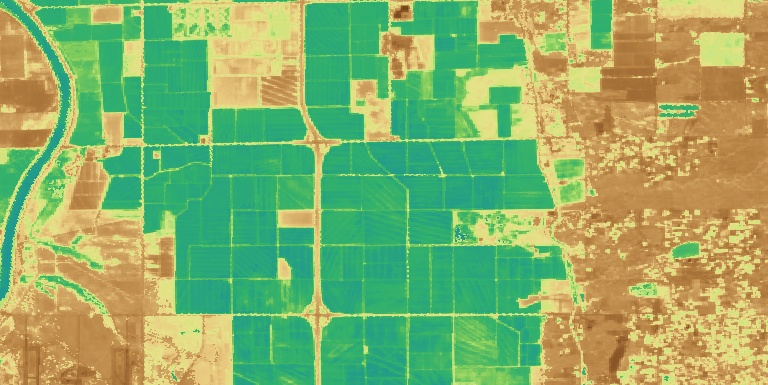

In [11]:
image_url = (
    ee.Image(monthly_coll.select(['et']).sum())
    #.reproject(crs=crs, scale=30)
    .getThumbURL({'min': 0.0, 'max': 350, 'palette': et_palette, 'region': region, 'dimensions': image_size})
)
Image(image_url, embed=True, format='png')